In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import helper

In [126]:

training = "traffic-signs-data/train.p"
testing = "traffic-signs-data/test.p"


with open(training, mode='rb') as file:
    train = pickle.load(file) 

with open(testing, mode='rb') as file:
    test = pickle.load(file)

In [127]:
X_tr, Y_tr = train['features'], train['labels']
X_te, Y_te = test['features'], test['labels']

classes = len(set(Y_tr))


print ("Training iputs shape: {}".format(X_tr.shape))
print ("Training labels shape: {}".format(Y_tr.shape))

print ("Testing iputs shape: {}".format(X_te.shape))
print ("Testing labels shape: {}".format(Y_te.shape))
print ("Number of classes {}". format(classes))

Training iputs shape: (39209, 32, 32, 3)
Training labels shape: (39209,)
Testing iputs shape: (12630, 32, 32, 3)
Testing labels shape: (12630,)
Number of classes 43


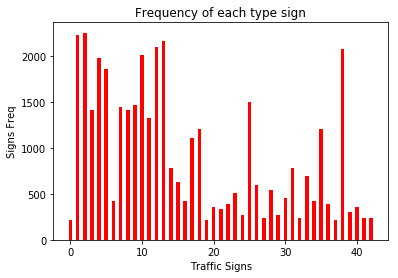

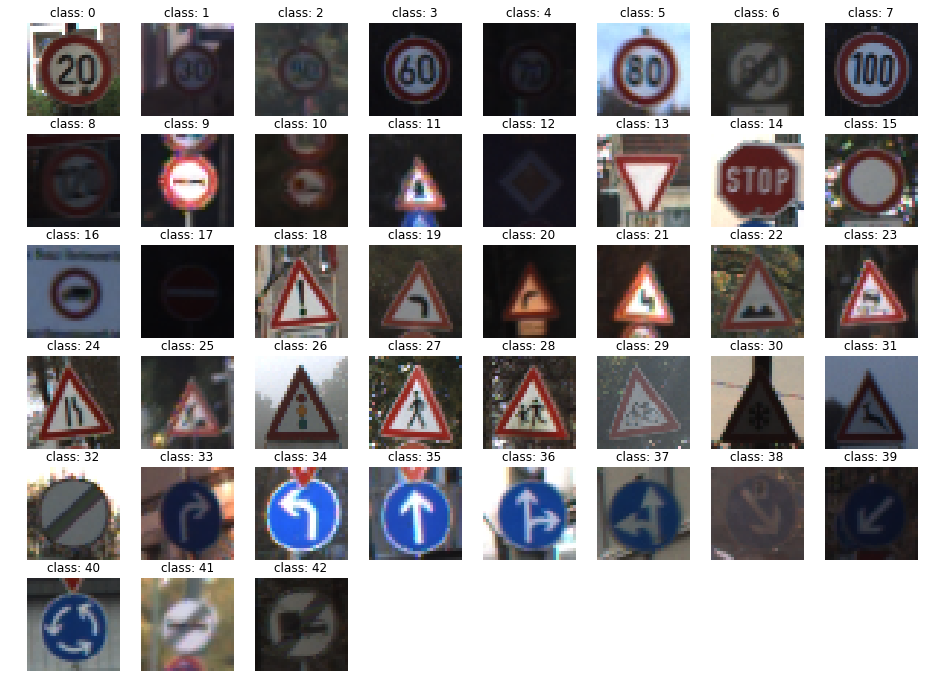

In [128]:
import random as rd

fig, ax = plt.subplots()
ax.bar(range(classes), np.bincount(Y_tr), 0.5, color='r')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Signs Freq')
ax.set_title('Frequency of each type sign')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(classes):
    j = rd.choice(np.where(Y_tr == i)[0])
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.title('class: {}'.format(i))
    plt.imshow(X_tr[j])

In [129]:
tf.reset_default_graph()
from sklearn.model_selection import train_test_split

l = len(X_tr)

X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr, Y_tr, test_size=0.3, random_state=0)

X_tr = np.reshape(X_tr, (-1, 32, 96))
X_val = np.reshape(X_val, (-1, 32, 96))




print(X_tr.shape)
print(X_te.shape)

(27446, 32, 96)
(12630, 32, 32, 3)


In [130]:
def stats(X_batch, Y_batch):
    total_loss = 0
    total_acc = 0
    samples = len(X_batch)
    #X_batch = np.reshape(X_batch, [-1, n_steps, n_inputs])
    sess = tf.get_default_session()
    for offset in range(0, samples, batch_size):
        end = offset+batch_size
        xs_batch, ys_batch = X_batch[offset:end], Y_batch[offset:end]
        loss_, acc = sess.run([loss, accuracy], feed_dict={x:xs_batch, 
                                                           y:ys_batch,
                                                           keep_prob:1.0})
        total_loss += (float(loss_)*xs_batch.shape[0])
        total_acc += (float(acc)*xs_batch.shape[0])

    return (total_loss)/samples, (total_acc)/samples

In [131]:

def RNN(x_, w, b):
    x_ = tf.transpose(x_, [1, 0, 2])
    x_ = tf.reshape(x_, [-1, n_inputs])
    
    
    hidden = tf.matmul(x_, w['hidden']) + b['hidden']
    hidden = tf.nn.relu(hidden)
    hidden = tf.split(hidden, n_steps, 0)
    rnn_layers = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(n_hidden), output_keep_prob=keep_prob) for _ in range(n_layers)]
    rnn_layers = tf.contrib.rnn.MultiRNNCell(rnn_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(rnn_layers, hidden, dtype=tf.float32)
    
    rnn_output = outputs[-1]
    return tf.matmul(rnn_output, w['out']) + b['out']
    
    
    

In [132]:
learning_rate = 1e-3
n_steps = 32 
n_inputs = 96

n_layers = 2
n_hidden = 512
n_classes = classes
batch_size = 128

w = {
    'hidden': tf.Variable(tf.random_normal([n_inputs, n_hidden])),
    'out'   : tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
b = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out'  : tf.Variable(tf.random_normal([n_classes]))
}


x = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_inputs], name='x')
y = tf.placeholder(dtype=tf.int32, shape=[None], name='y')
keep_prob = tf.placeholder(dtype=tf.float32)
y_hot = tf.one_hot(y, classes, name='one_hot')
#keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')


In [133]:
logits = RNN(x, w, b)

In [134]:
softmax = tf.nn.softmax(logits, name='logits')

step = tf.Variable(0, trainable=False)
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_hot))
with tf.name_scope("train_step"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='optimizer').minimize(loss)

prediction = tf.equal(tf.argmax(softmax, 1), tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

Initializing Training
EPOCH 1
Validation Loss = 3.395 and Validation Accuracy = 10.184 %
EPOCH 2
Validation Loss = 3.310 and Validation Accuracy = 11.893 %
EPOCH 3
Validation Loss = 3.224 and Validation Accuracy = 14.852 %
EPOCH 4
Validation Loss = 3.167 and Validation Accuracy = 16.169 %
EPOCH 5
Validation Loss = 3.113 and Validation Accuracy = 13.755 %
EPOCH 6
Validation Loss = 3.069 and Validation Accuracy = 14.979 %
EPOCH 7
Validation Loss = 3.033 and Validation Accuracy = 16.305 %
EPOCH 8
Validation Loss = 2.978 and Validation Accuracy = 18.754 %
EPOCH 9
Validation Loss = 2.994 and Validation Accuracy = 18.320 %
EPOCH 10
Validation Loss = 2.956 and Validation Accuracy = 16.764 %
EPOCH 11
Validation Loss = 2.954 and Validation Accuracy = 19.068 %
EPOCH 12
Validation Loss = 2.942 and Validation Accuracy = 17.649 %
EPOCH 13
Validation Loss = 2.763 and Validation Accuracy = 21.678 %
EPOCH 14
Validation Loss = 2.785 and Validation Accuracy = 22.639 %
EPOCH 15
Validation Loss = 2.710 an

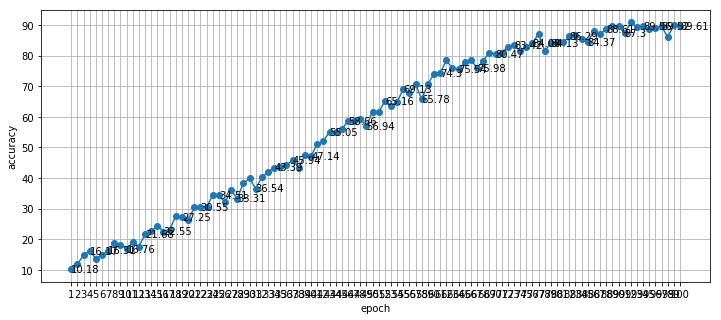

In [135]:
acc_map = []

from sklearn.utils import shuffle

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_loss_ = []
test_acc_ = []
epochs = 100
samples = len(X_tr)

count = 0
print("Initializing Training")
try:
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for epoch in range(epochs):
            X_tr, Y_tr = shuffle(X_tr, Y_tr)
            for offset in range(0, samples, batch_size):
                end = offset+batch_size
                xs_batch, ys_batch = X_tr[offset:end], Y_tr[offset:end]
                loss_, _, acc_ = sess.run([loss, optimizer, accuracy], feed_dict={x: xs_batch, 
                                                                              y: ys_batch,
                                                                              keep_prob: 0.5})    
                #if count % 100 == 0:
                    #print('Epoch {} Loss = {} and Accuracy {}'.format(epoch, loss_, 100 * acc_))

                train_loss.append(loss_)
                train_acc.append(acc_)
            validation_loss, validation_acc = stats(X_val, Y_val)
                #count += 1
            acc_map.append(round(validation_acc*100, 2))
            print("EPOCH {}".format(epoch + 1))
            print ("Validation Loss = {:.3f} and Validation Accuracy = {:.3f} %".format(validation_loss, 100 *validation_acc))
        plt.figure(figsize=(12, 5))
        plt.xticks(range(1, epochs+1))
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.grid(True)
        plt.plot(range(1, epochs+1), acc_map, '-o')
        for i, j in list(zip(range(1, epochs+1), acc_map))[0::3]:
            plt.text(i, j-1, str(j))
        print ("Test Loss {} and Test Accuracy {:.3f} %".format(test_loss, 100 *test_acc))
except KeyboardInterrupt:
    print('Training interrupted')